# 2D example

The operator is assume to be separable: $\phi(x,y) = \phi_1(x)\phi_2(y)$. Recover $\mu$ from 
$$
\int \phi(x,y) d\mu(x,y)
$$

In [21]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
import time

import mmd as mmd
import operators as myops
import lasso as ls
import continuous_BP as cbp
from helper import prune,generate_plots
from mmd import mmd_laplace as error_fun
from importlib import reload  # Python 3.4+
from numpy import linspace
reload(ls)
reload(myops)
reload(mmd)


<module 'mmd' from '/Users/u2272691/Documents/GitHub/continuous-BP/Python/cBP_paper/mmd.py'>

Define discretized operators

In [22]:
#Lasso on the grid
def Grid_Lasso(A,B,y_obs,la,tol=1e-8):
    
    #forward and adjoint operators
    def Op_lasso(A,B):
        Bt = B.T 
        Bc = B.conjugate()
        Act = A.conjugate().T

        def FWD(x):
            x0 = x[:,:,0]
            return (A@x0)@Bt

        def ADJ(x):
            z = (Act@x)@Bc
            return z[:,:,None]  
        return FWD, ADJ
    FWD_lasso,ADJ_lasso = Op_lasso(A,B)

    a = ls.Lasso_Tensor(FWD_lasso,ADJ_lasso, y_obs,la)

    return a.reshape(-1)



In [23]:
def generate_random_signal(s,xgrid1,xgrid2,shift,minsep=1,pos=True):
    
    P = np.random.permutation(len(xgrid1)//minsep)
    idx = P[:s]*minsep
    t0 = xgrid1[idx] + shift[0]
    
    
    P = np.random.permutation(len(xgrid2)//minsep)
    idx = P[:s]*minsep
    t1 = xgrid2[idx] + shift[1]
    
    if pos:
        a = np.random.rand(s,)+2
    else:
        a = (np.random.rand(s,)+2)*np.sign(np.random.randn(s,))+1j* (np.random.rand(s,)+2)*np.sign(np.random.randn(s,))
    return a, np.stack((t0, np.random.permutation(t1)),axis=1)



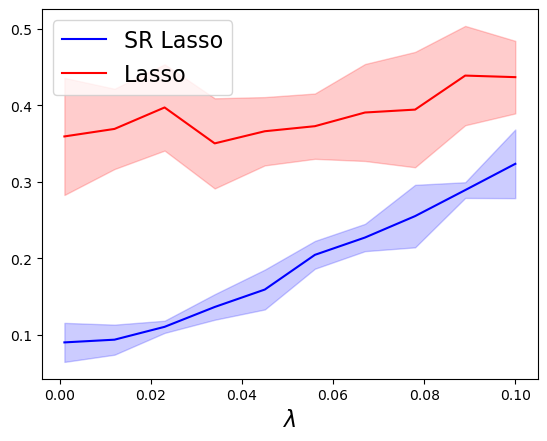

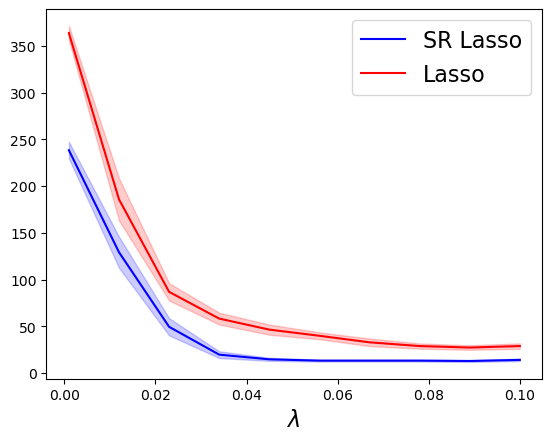

In [24]:

nx= [25,25] #grid sizes

xgrid1 = linspace(0,1,nx[0])
xgrid2 = linspace(0,1,nx[1])
points = np.array([np.array([x,y]) for x in xgrid1 for y in xgrid2])


#define Fourier
fq = 8
Phi,  dPhi = myops.getFourierOp(fq)
A, dA = Phi(xgrid1), dPhi(xgrid1)

#define Fourier
fq = 8
Psi,  dPsi = myops.getFourierOp(fq)
B, dB = Psi(xgrid1), dPsi(xgrid2)


'''
#Define Gaussian
M = 20
tvec = np.linspace(0,1,M)
sigma=0.1
Phi, A, dA = myops.getGaussianMatrices(tvec,sigma,xgrid1)


#define Laplace
T = 3
tvec = np.linspace(0,1,T)
Psi,  B, dB = myops.getLaplaceMatrices(tvec,xgrid2)


'''
pos = False
Runs = 5
L= 10
alpha_max = .1
alpha_vals = np.logspace(-6,np.log10(alpha_max),L)
alpha_vals = np.linspace(0.001,alpha_max,L)


tol=1e-2
s=3
h1 = (xgrid1[1]-xgrid1[0])
h2 = (xgrid2[1]-xgrid2[0])
spacing = 0.2


err_lasso =  np.zeros((L,Runs))
err_srlasso = np.zeros((L,Runs))

supp_lasso = np.zeros((L,Runs))
supp_srlasso = np.zeros((L,Runs))

for i in range(L):
    alpha = alpha_vals[i]

    for r in range(Runs):
        a0, t0 = generate_random_signal(s,xgrid1,xgrid2,[spacing*h1,spacing*h2],minsep=3,pos=True)
        y_true = np.einsum('kj,lj->kl', Phi(t0[:,0]), Psi(t0[:,1])*a0[None,:]) 

        noise_lev = 0.01*np.linalg.norm(y_true)/np.sqrt(len(y_true))
        y_obs = y_true +noise_lev*np.random.randn( *y_true.shape) 

        # run SR Lasso
        tol=1e-4
        tau1,tau2=1,1
        a,b1,b2 = cbp.SRLasso_2DTensor(A, dA, B, dB, y_obs,alpha,[tau1,tau2])
        a,grid = prune(a, points+ np.stack((b1,b2),axis=1), tol)
        grid = np.mod(grid,1)

        err_srlasso[i,r] = error_fun(t0,a0,grid,a) 
        supp_srlasso[i,r] = len(a)
        
        #run Lasso
        a_lasso = Grid_Lasso(A,B, y_obs,alpha)
        a_lasso ,x_lasso = prune(a_lasso,points,tol)
        x_lasso = np.mod(x_lasso,1)
        
        err_lasso[i,r] = error_fun(t0,a0,x_lasso,a_lasso) 
        supp_lasso[i,r ] = len(a_lasso)

Plots = [err_srlasso,err_lasso]
labels = ['SR Lasso','Lasso']
filename = '2DFourier_'+'N'+str(nx[0])+'s'+str(s)+'_pos='+str(pos)+'Err'+'.png'
generate_plots(Plots, labels,filename,xlabel='$\lambda$', xaxis = alpha_vals)



Plots = [supp_srlasso,supp_lasso]
labels = ['SR Lasso','Lasso']
filename = '2DFourier_'+'N'+str(nx[0])+'s'+str(s)+'_pos='+str(pos)+'Supp'+'.png'
generate_plots(Plots, labels,filename,xlabel='$\lambda$', xaxis = alpha_vals)

